#https://github.com/cornellius-gp/gpytorch/issues/1743
#[Question] Implementing multi-output multi-task approximate GP #1743

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats


## DOE Data

In [37]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
df.head()

1843


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [38]:
cols_group = ['Project','Protein','Modality', 'Stress_Condition','Temp_C_', 'Time_Days_']
cols_feature01 = ['Buffer','NaCl_mM_', 'pH']
cols_feature02 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
#cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
cols_target = ['UP_SEC_Monomer','UP_SEC_LMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


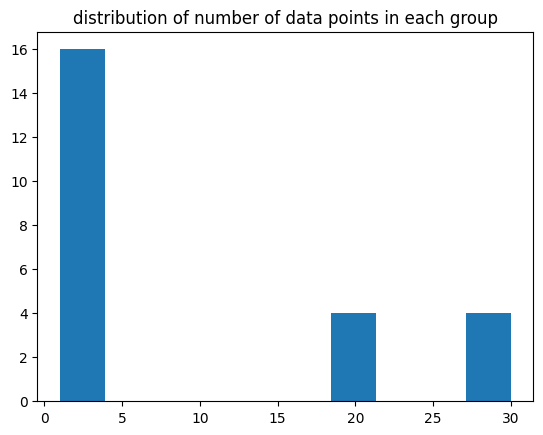

In [39]:
# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [40]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)


print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
#split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
#split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
#split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]


True
True


In [41]:
#input space 8==9==11 != 10
split8 = splits_identifier[8]
split9 = splits_identifier[9]
split10 = splits_identifier[10]
split11 = splits_identifier[11]

split8_formulation_df = split8[1][cols_feature01]
split8_formulation_df.reset_index(drop = True,inplace =True)
split9_formulation_df = split9[1][cols_feature01]
split9_formulation_df.reset_index(drop = True,inplace =True)
split10_formulation_df = split10[1][cols_feature01]
split10_formulation_df.reset_index(drop = True,inplace =True)
split11_formulation_df = split11[1][cols_feature01]
split11_formulation_df.reset_index(drop = True,inplace =True)

print('----does 8 equal 9---')
print(split8_formulation_df.equals(split9_formulation_df)) 
print('----does 8 equal 10---')
print(split8_formulation_df.equals(split10_formulation_df))
print('----does 8 equal 11---')
print(split8_formulation_df.equals(split11_formulation_df))
print('----does 9 equal 10---')
print(split9_formulation_df.equals(split10_formulation_df))
print('----does 9 equal 11---')
print(split9_formulation_df.equals(split11_formulation_df))
print('----does 10 equal 11---')
print(split10_formulation_df.equals(split11_formulation_df))#! split 10 has a different input than 8,9,11

split8_target_df = split8[1][cols_target]
split8_target_df.reset_index(drop = True,inplace =True)
#split8_target_df.columns = [c+'_8' for c in split8_target_df.columns]

split9_target_df = split9[1][cols_target]
split9_target_df.reset_index(drop = True,inplace =True)
#split9_target_df.columns = [c+'_9' for c in split9_target_df.columns]

split10_target_df = split10[1][cols_target]
split10_target_df.reset_index(drop = True,inplace =True)
#split10_target_df.columns = [c+'_10' for c in split10_target_df.columns]

split11_target_df = split11[1][cols_target]
split11_target_df.reset_index(drop = True,inplace =True)
#split11_target_df.columns = [c+'_11' for c in split11_target_df.columns]

----does 8 equal 9---
True
----does 8 equal 10---
False
----does 8 equal 11---
True
----does 9 equal 10---
False
----does 9 equal 11---
True
----does 10 equal 11---
False


In [42]:
def remove_col_outlier(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    keep_inds = ~((df[col] < (Q1 - 2 * IQR)) |(df[col] > (Q3 + 2 * IQR)))
    df = df[keep_inds]
    return df,keep_inds

In [43]:

split1_target_df,keep1_inds = remove_col_outlier(split1_target_df,cols_target[1])
split3_target_df,keep3_inds = remove_col_outlier(split3_target_df,cols_target[1])
split5_target_df,keep5_inds = remove_col_outlier(split5_target_df,cols_target[1])

split1_formulation_df = split1_formulation_df[(keep1_inds)]
split3_formulation_df = split3_formulation_df[(keep3_inds)]
split5_formulation_df = split5_formulation_df[(keep5_inds)]

print(split1_formulation_df.shape)
print(split3_formulation_df.shape)
print(split5_formulation_df.shape)

split8_target_df,keep8_inds = remove_col_outlier(split8_target_df,cols_target[1])
split9_target_df,keep9_inds = remove_col_outlier(split9_target_df,cols_target[1])
split10_target_df,keep10_inds = remove_col_outlier(split10_target_df,cols_target[1])
split11_target_df,keep11_inds = remove_col_outlier(split11_target_df,cols_target[1])


split8_formulation_df = split8_formulation_df[(keep8_inds)]
split9_formulation_df = split9_formulation_df[(keep9_inds)]
split10_formulation_df = split10_formulation_df[(keep10_inds)]
split11_formulation_df = split11_formulation_df[(keep11_inds)]

print(split8_formulation_df.shape)
print(split9_formulation_df.shape)
print(split10_formulation_df.shape)
print(split11_formulation_df.shape)



(21, 3)
(18, 3)
(21, 3)
(30, 3)
(29, 3)
(29, 3)
(26, 3)


In [114]:
ls_df_x = [split8_formulation_df,split9_formulation_df,split10_formulation_df,split11_formulation_df]
#ls_df_x = [split8_formulation_df,split11_formulation_df]
for i,tmp_df_x in enumerate(ls_df_x):
        tmp_df_x['task_ind'] = i
df_x = pd.concat(ls_df_x)
df_x.reset_index(inplace=True, drop = True)
df_x.head()

,Buffer,NaCl_mM_,pH,task_ind
0,Acetate,0,4.5,0
1,Acetate,0,5.0,0
2,Acetate,0,5.6,0
3,Acetate,0,6.2,0
4,Citrate,0,5.6,0


In [115]:
ls_df_y = [split8_target_df,split9_target_df,split10_target_df,split11_target_df]
#ls_df_y = [split8_target_df,split11_target_df]
df_y = pd.concat(ls_df_y,axis = 0)
df_y.reset_index(inplace = True, drop = True)
df_y.head()

,UP_SEC_Monomer,UP_SEC_LMW
0,90.71,9.29
1,90.70,9.30
2,90.64,9.36
3,90.65,9.35
4,91.04,8.96


In [116]:
#convert Buffer column to labels
x_name = 'Buffer'
labels, categories = factorize(df_x[x_name])
df_x[x_name+"_label"] = labels


#onehot encoding
n30_total_df = pd.get_dummies(df_x, columns = ['Buffer'])
print(n30_total_df.head())

df_x['Buffer_Acetate'] = n30_total_df['Buffer_Acetate'].astype(int)
df_x['Buffer_Citrate'] = n30_total_df['Buffer_Citrate'].astype(int)
df_x['Buffer_Histidine'] = n30_total_df['Buffer_Histidine'].astype(int)
print(df_x.head())

   NaCl_mM_   pH  task_ind  Buffer_label  Buffer_Acetate  Buffer_Citrate  \
0         0  4.5         0             0            True           False   
1         0  5.0         0             0            True           False   
2         0  5.6         0             0            True           False   
3         0  6.2         0             0            True           False   
4         0  5.6         0             1           False            True   

   Buffer_Histidine  
0             False  
1             False  
2             False  
3             False  
4             False  
    Buffer  NaCl_mM_   pH  task_ind  Buffer_label  Buffer_Acetate  \
0  Acetate         0  4.5         0             0               1   
1  Acetate         0  5.0         0             0               1   
2  Acetate         0  5.6         0             0               1   
3  Acetate         0  6.2         0             0               1   
4  Citrate         0  5.6         0             1               0 

In [117]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


#model_option = 'multi-task-single-output'
model_option = 'simpleGP'
x_scale_option = 'x-minmax'
y_scale_option = 'y-stand'
#cate_transform_option = 'ohe'
cate_transform_option = 'label'

cate_option = ['Buffer']

#output_rank_option = 1 #if 0, no correlation between output
task_rank_option = 4#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'


model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_label = 'n_cate_var_'+str(len(cate_option))
cate_transform_label = 'cate_transform_'+cate_transform_option

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''



folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_label,cate_transform_label,
                        task_rank_label,lik_rank_label])

figPath = 'output/dpsdata-02132025/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [118]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

def rf_sklearn(X_train,y_train,X_test,y_test,feature_names,tmp_col_y,figPath,is_plot_imp = False):
    rf = RandomForestRegressor(random_state= 10)
    rf.fit(X_train,y_train)
    y_train_pred = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    """
    test_var = metrics.mean_squared_error(y_test, y_pred)
    train_var = metrics.mean_squared_error(y_train, y_train_pred)
    test_std = np.sqrt(test_var)
    train_std = np.sqrt(train_var)
    """

    test_std = np.abs(y_test - y_pred)
    train_std = np.abs(y_train - y_train_pred)
    
    importances=rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    if is_plot_imp:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(tmp_col_y + " Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        figName = tmp_col_y + 'featureImp.jpg'
        plt.savefig(os.path.join(figPath,figName))
    
    return y_train_pred, train_std, y_pred, test_std, forest_importances

In [119]:
# We will use the simplest form of GP model, exact inference
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(t_train_x, t_train_y, likelihood)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(t_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, t_train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    
    # Set into eval mode
    model.eval()
    model.likelihood.eval()


    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = model.likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = model.likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()
    return test_mean, test_lower, test_upper, train_mean, train_lower, train_upper


In [120]:
##Split the data into training and testing sets
cols_feature = cols_feature01
s = set(cate_option)
cols_numeric = [x for x in cols_feature if x not in s]
cols_numeric

if len(cate_option) == 0:
    cols_cate = []
    cols_feature_new = cols_feature
else:
    cols_cate = [x + '_label' for x in cate_option]
    cols_feature_new = cols_cate + list(cols_numeric) + ['task_ind']

cols_target = list(df_y.columns)

df_x_select = df_x[cols_feature_new]


df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x_select, df_y, test_size=0.2, random_state=0,stratify=df_x_select['task_ind'])

In [121]:
from sklearn.compose import ColumnTransformer
#cols_exception = []
cols_exception = cols_cate + ['task_ind']
if x_scale_label == 'x-minmax':
    xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),
                          df_X_train.columns.difference(cols_exception))], 
                         remainder = 'passthrough')

    scaled_X_train=xct.fit_transform(df_X_train) 
    scaled_X_test=xct.transform(df_X_test)

    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
elif x_scale_label == 'no-x-scale':
    scaled_X_train=df_X_train.to_numpy()
    scaled_X_test=df_X_test.to_numpy()

    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

Iter 1/50 - Loss: 1.418   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.408   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 1.397   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 1.386   lengthscale: 0.554   noise: 0.554
Iter 5/50 - Loss: 1.375   lengthscale: 0.513   noise: 0.513
Iter 6/50 - Loss: 1.363   lengthscale: 0.474   noise: 0.474
Iter 7/50 - Loss: 1.351   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 1.341   lengthscale: 0.405   noise: 0.403
Iter 9/50 - Loss: 1.334   lengthscale: 0.379   noise: 0.370
Iter 10/50 - Loss: 1.328   lengthscale: 0.360   noise: 0.339
Iter 11/50 - Loss: 1.322   lengthscale: 0.348   noise: 0.311
Iter 12/50 - Loss: 1.315   lengthscale: 0.344   noise: 0.284
Iter 13/50 - Loss: 1.307   lengthscale: 0.346   noise: 0.259
Iter 14/50 - Loss: 1.299   lengthscale: 0.351   noise: 0.236
Iter 15/50 - Loss: 1.291   lengthscale: 0.358   noise: 0.215
Iter 16/50 - Loss: 1.285   lengthscale: 0.366   noise: 0.196
Iter 17/50 - Loss: 1.279   length

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:2

Iter 41/50 - Loss: 1.345   lengthscale: 0.235   noise: 0.129
Iter 42/50 - Loss: 1.344   lengthscale: 0.234   noise: 0.126
Iter 43/50 - Loss: 1.345   lengthscale: 0.234   noise: 0.123
Iter 44/50 - Loss: 1.345   lengthscale: 0.233   noise: 0.121
Iter 45/50 - Loss: 1.345   lengthscale: 0.233   noise: 0.119
Iter 46/50 - Loss: 1.346   lengthscale: 0.233   noise: 0.117
Iter 47/50 - Loss: 1.345   lengthscale: 0.233   noise: 0.117
Iter 48/50 - Loss: 1.345   lengthscale: 0.233   noise: 0.116
Iter 49/50 - Loss: 1.345   lengthscale: 0.232   noise: 0.116
Iter 50/50 - Loss: 1.345   lengthscale: 0.232   noise: 0.117
Iter 1/50 - Loss: 1.287   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.273   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.262   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.254   lengthscale: 0.850   noise: 0.555
Iter 5/50 - Loss: 1.250   lengthscale: 0.897   noise: 0.516
Iter 6/50 - Loss: 1.246   lengthscale: 0.930   noise: 0.480
Iter 7/50 - Loss: 1.244   leng

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:2

Iter 21/50 - Loss: 1.355   lengthscale: 0.242   noise: 0.384
Iter 22/50 - Loss: 1.352   lengthscale: 0.250   noise: 0.360
Iter 23/50 - Loss: 1.351   lengthscale: 0.257   noise: 0.336
Iter 24/50 - Loss: 1.349   lengthscale: 0.261   noise: 0.315
Iter 25/50 - Loss: 1.348   lengthscale: 0.262   noise: 0.296
Iter 26/50 - Loss: 1.346   lengthscale: 0.260   noise: 0.279
Iter 27/50 - Loss: 1.345   lengthscale: 0.254   noise: 0.261
Iter 28/50 - Loss: 1.344   lengthscale: 0.248   noise: 0.242
Iter 29/50 - Loss: 1.343   lengthscale: 0.240   noise: 0.223
Iter 30/50 - Loss: 1.342   lengthscale: 0.233   noise: 0.204
Iter 31/50 - Loss: 1.342   lengthscale: 0.228   noise: 0.185
Iter 32/50 - Loss: 1.341   lengthscale: 0.225   noise: 0.166
Iter 33/50 - Loss: 1.340   lengthscale: 0.223   noise: 0.149
Iter 34/50 - Loss: 1.339   lengthscale: 0.223   noise: 0.133
Iter 35/50 - Loss: 1.338   lengthscale: 0.224   noise: 0.119
Iter 36/50 - Loss: 1.338   lengthscale: 0.226   noise: 0.107
Iter 37/50 - Loss: 1.337

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:2

Iter 19/50 - Loss: 1.114   lengthscale: 0.630   noise: 0.154
Iter 20/50 - Loss: 1.106   lengthscale: 0.635   noise: 0.141
Iter 21/50 - Loss: 1.099   lengthscale: 0.638   noise: 0.129
Iter 22/50 - Loss: 1.092   lengthscale: 0.632   noise: 0.118
Iter 23/50 - Loss: 1.086   lengthscale: 0.620   noise: 0.108
Iter 24/50 - Loss: 1.080   lengthscale: 0.609   noise: 0.099
Iter 25/50 - Loss: 1.075   lengthscale: 0.604   noise: 0.091
Iter 26/50 - Loss: 1.070   lengthscale: 0.605   noise: 0.084
Iter 27/50 - Loss: 1.066   lengthscale: 0.603   noise: 0.078
Iter 28/50 - Loss: 1.063   lengthscale: 0.594   noise: 0.072
Iter 29/50 - Loss: 1.060   lengthscale: 0.582   noise: 0.067
Iter 30/50 - Loss: 1.058   lengthscale: 0.576   noise: 0.062
Iter 31/50 - Loss: 1.056   lengthscale: 0.575   noise: 0.058
Iter 32/50 - Loss: 1.055   lengthscale: 0.573   noise: 0.055
Iter 33/50 - Loss: 1.054   lengthscale: 0.567   noise: 0.052
Iter 34/50 - Loss: 1.054   lengthscale: 0.558   noise: 0.049
Iter 35/50 - Loss: 1.054

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/1838208052.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:2

         Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  Task_2_Output_2  \
MAE                 1.20             0.16             0.45             0.57   
MAE2                0.22             0.19             0.26             0.43   
MSE                 6.63             0.04             0.33             0.44   
RMSE                2.58             0.20             0.58             0.66   
MAPE                0.01             0.02             0.00             0.06   
MAXE                6.29             0.34             1.12             1.29   
EVS               -77.72             0.65             0.44             0.28   
R2                -92.36             0.65             0.43             0.25   
AVG_STD             2.15             0.86             0.68             1.02   
MIN_STD             1.29             0.76             0.62             0.92   
MAX_STD             3.44             0.96             0.80             1.05   

         Task_3_Output_1  Task_3_Output_2  Task_4_O

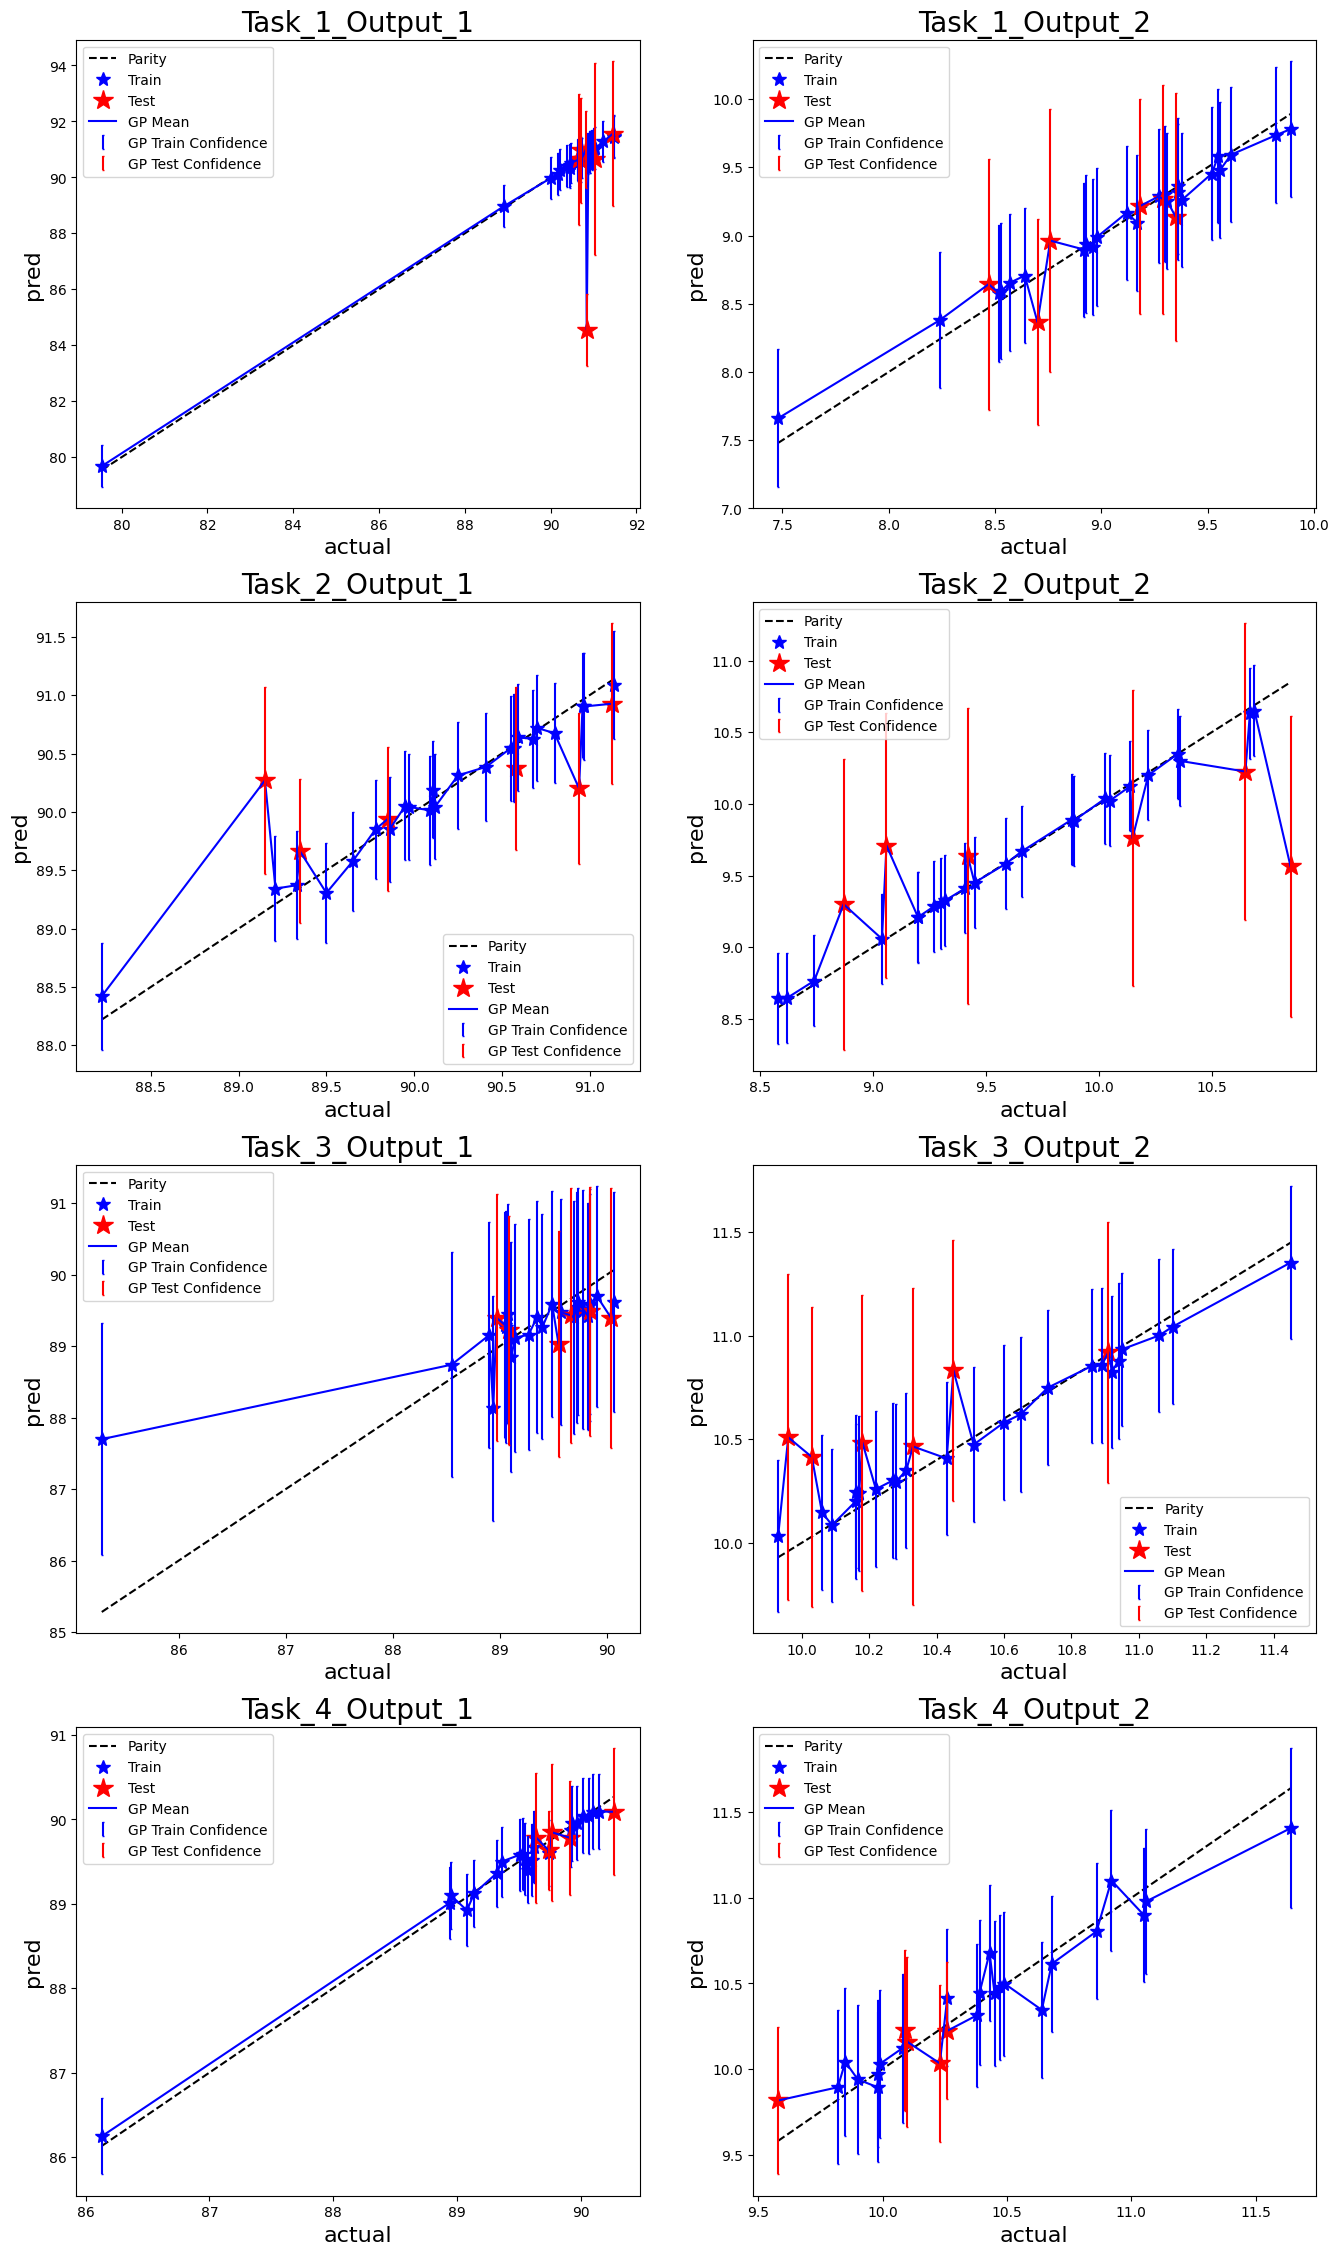

In [122]:
#simpleGP and rf


y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False

plot_axis_lb = df_y[cols_target].min(axis = 0) - 0.4* df_y[cols_target].std(axis = 0)
plot_axis_ub = df_y[cols_target].max(axis = 0) + 0.4*  df_y[cols_target].std(axis = 0)

num_outputs = len(cols_target)
num_tasks = len(ls_df_x)

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
cols_target_wide = []
cols_feature_new = df_X_train.columns.difference(['task_ind'])
for task_ind in range(num_tasks):
  y_train_task = df_y_train.iloc[scaled_X_train[:,-1]==task_ind,:].to_numpy()
  y_test_task = df_y_test.iloc[scaled_X_test[:,-1]==task_ind,:].to_numpy()

  t_train_x_task = t_train_x[t_train_x[:,-1]==task_ind]
  t_test_x_task = t_test_x[t_test_x[:,-1]==task_ind]

  arr_train_x = t_train_x_task.detach().numpy()
  arr_test_x = t_test_x_task.detach().numpy()
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+str(j+1)
    cols_target_wide.append(tmp_col_y)
    if model_option == 'rf':
      X_train = scaled_X_train[scaled_X_train[:,-1]==task_ind,:-1]
      X_test = scaled_X_test[scaled_X_test[:,-1]==task_ind,:-1]
      y_train = df_y_train.iloc[scaled_X_train[:,-1]==task_ind,j].to_numpy()
      y_true = df_y_test.iloc[scaled_X_test[:,-1]==task_ind,j].to_numpy()
      mean_train_pred, std_train_pred, mean_test_pred, std_test_pred, _, = rf_sklearn(X_train,
                                                                                      y_train,
                                                                                      X_test,
                                                                                      y_true,
                                                                                      cols_feature_new,
                                                                                      tmp_col_y,figPath,
                                                                                      is_plot_imp = False)
      #mean_train = mean_train_pred
      y_pred = mean_test_pred
    elif model_option == 'simpleGP':
      if y_scale_label == 'y-robust' and model_option == 'simpleGP':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(y_train_task[:,j].reshape(-1,1))
      elif y_scale_label == 'y-stand' and model_option == 'simpleGP':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(y_train_task[:,j].reshape(-1,1))
      elif y_scale_label == 'y-minmax' and model_option == 'simpleGP':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(y_train_task[:,j].reshape(-1,1))
      else:
        scaled_y_train = y_train_task[:,j]
      
      t_train_y_task = torch.Tensor(scaled_y_train).flatten()
      test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = simpleGP_gpytorch(t_train_x_task,t_test_x_task,t_train_y_task,training_iter = 50)
    
      
      t_test_y_task = torch.Tensor(y_test_task[:,j].astype(np.float32))
      arr_test_y = t_test_y_task.detach().numpy()

      if y_scale_label=='no-y-scale':
        arr_train_y = t_train_y_task.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
      else:
        arr_train_y = y_scaler.inverse_transform(scaled_y_train)
        arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
        arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
        arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

        arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
        arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
        arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

      y_true = arr_test_y
      y_pred = arr_test_mean
      y_train = arr_train_y
      mean_train_pred = arr_train_mean
      std_train_pred = arr_train_mean - arr_train_lower
      std_test_pred = arr_test_mean - arr_test_lower

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if model_option != 'rf':
      if uncertainty_figure_option == 'shade':
      # Shade in confidence
        y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
      else:
        yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
        yerr = yerr.values.tolist()
        yerr_train = df_train_comp['pred'] - df_train_comp['lower']
        yerr_train = yerr_train.values.tolist()
        yerr_test = df_test_comp['pred'] - df_test_comp['lower']
        yerr_test = yerr_test.values.tolist()
        y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
        y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      #y_axes[a].set_xlim([-2.5,2.5])
      #y_axes[a].set_ylim([-2.5,2.5])
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    if model_option == 'rf':
      y_axes[a].legend(['Parity','Train','Test','GP Mean'])
    else:
      y_axes[a].legend(['Parity','Train','Test','GP Mean','GP Train Confidence','GP Test Confidence'])
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1),fontsize=20)
    y_axes[a].set_xlabel('actual',fontsize=16)
    y_axes[a].set_ylabel('pred',fontsize=16)
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    if model_option != 'rf':
      arr_test_metrics[8,a] = round(np.mean(std_test_pred),2)
      arr_test_metrics[9,a] = round(np.min(std_test_pred),2)
      arr_test_metrics[10,a] = round(np.max(std_test_pred),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    if model_option != 'rf':
      arr_train_metrics[8,a] = round(np.mean(std_train_pred),2)
      arr_train_metrics[9,a] = round(np.min(std_train_pred),2)
      arr_train_metrics[10,a] = round(np.max(std_train_pred),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

##multi-task




In [19]:
#M3GPR-O
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_tasks, rank = 0):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [20]:
#M3GPR-R
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [35]:
ls_model = ['rf','simpleGP-sklearn','simpleGP-gpytorch','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust', 'y-norm-sklearn']
ls_n_cate = ['no-cate','one-cate']
ls_cate_transform = ['label','ohe','LVGP','partial-LMGP','partial-LMGP-per-task','full-LMGP-per-task']
ls_output_rank_option = [0,1,2]
ls_task_rank_option = [0,1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_stratify_task = ['not-stratify','stratify-x']

In [98]:
#model_option = 'rf'
#model_option = 'simpleGP'
#model_option = 'multi-task-single-output'
model_option = 'multi-task-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax' #GaussianProcessRegressor has a normalize_y argument


#cate_option = cols_feature.difference(['NaCl_mM_','Trehalose_w_v_'])
#cate_option = cols_feature
#cate_option = cols_feature.difference(['NaCl_mM_'])
cate_option = ['Buffer']
if len(cate_option) > 0:
        #cate_transform_option = 'full-LMGP-per-task'
        #cate_transform_option = 'partial-LMGP-per-task'
        cate_transform_option = 'label'
else:
        cate_transform_option = ''
if model_option != 'simpleGP':
        output_rank_option = 2
        task_rank_option = df_x['task_ind'].unique().shape[0]
        lik_rank_option = 1
else:
        output_rank_option = ''
        lik_rank_option = ''
        task_rank_option = ''

#stratify_option = 'stratify-x'

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_label = 'n_cate_var_'+str(len(cate_option))
cate_transform_label = 'cate_transform_'+cate_transform_option
if model_option != 'simpleGP':
        output_rank_label = 'output_rank_'+str(output_rank_option)
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        output_rank_label = str(output_rank_option)
        task_rank_label = str(task_rank_option)
        lik_rank_label = str(lik_rank_option)

"""

remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)



split_label = split_option
stratify_label = stratify_option
"""

#folder_name = '-'.join([model_label,task_rank_label,output_rank_label,lik_rank_label,x_scale_label,y_scale_label,cate_transform_label,
#                        remove_pred_outlier_label,split_label,stratify_label])

folder_name = '-'.join([model_label,output_rank_label,task_rank_label,lik_rank_label,
                        x_scale_label,y_scale_label,cate_label,cate_transform_label])

figPath = 'output/dpsdata-02132025-group8-11/'+folder_name

if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/dpsdata-02132025-group8-11/multi-task-multi-output-output_rank_2-task_rank_2-lik_rank_1-x-minmax-y-minmax-n_cate_var_1-cate_transform_label


In [99]:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    #scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)

In [108]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

Iter 1/120 - Loss: 1.315
Iter 2/120 - Loss: 1.206
Iter 3/120 - Loss: 1.101
Iter 4/120 - Loss: 1.005
Iter 5/120 - Loss: 0.917
Iter 6/120 - Loss: 0.838
Iter 7/120 - Loss: 0.766
Iter 8/120 - Loss: 0.696
Iter 9/120 - Loss: 0.627
Iter 10/120 - Loss: 0.560
Iter 11/120 - Loss: 0.501
Iter 12/120 - Loss: 0.454
Iter 13/120 - Loss: 0.415
Iter 14/120 - Loss: 0.374
Iter 15/120 - Loss: 0.325
Iter 16/120 - Loss: 0.266
Iter 17/120 - Loss: 0.200
Iter 18/120 - Loss: 0.136
Iter 19/120 - Loss: 0.083
Iter 20/120 - Loss: 0.039
Iter 21/120 - Loss: -0.002
Iter 22/120 - Loss: -0.039
Iter 23/120 - Loss: -0.071
Iter 24/120 - Loss: -0.105
Iter 25/120 - Loss: -0.143
Iter 26/120 - Loss: -0.189
Iter 27/120 - Loss: -0.235
Iter 28/120 - Loss: -0.273
Iter 29/120 - Loss: -0.300
Iter 30/120 - Loss: -0.325
Iter 31/120 - Loss: -0.356
Iter 32/120 - Loss: -0.392
Iter 33/120 - Loss: -0.424
Iter 34/120 - Loss: -0.447
Iter 35/120 - Loss: -0.466
Iter 36/120 - Loss: -0.481
Iter 37/120 - Loss: -0.494
Iter 38/120 - Loss: -0.507
Ite

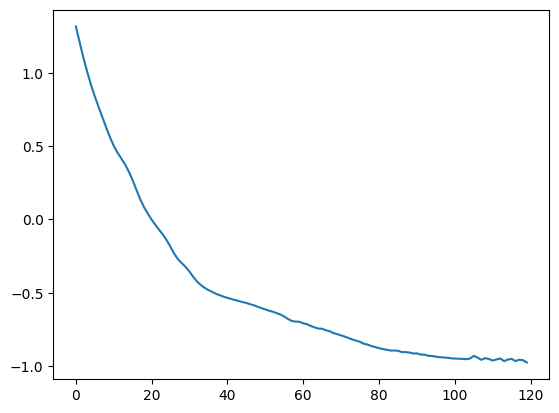

In [109]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 120
ls_loss = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    ls_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
plt.plot(ls_loss)

In [110]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [111]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #t_std_train = train_mean - train_lower
        #t_std_test = test_mean - test_lower

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [112]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/3187160543.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/3187160543.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8833/3187160543.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var

         Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  Task_2_Output_2
MAE                 1.22             0.20             0.73             0.38
MAE2                0.36             0.22             0.24             0.22
MSE                 6.03             0.05             1.81             0.32
RMSE                2.46             0.23             1.35             0.56
MAPE                0.01             0.02             0.01             0.03
MAXE                5.97             0.37             3.26             1.29
EVS               -75.22             0.54             0.18             0.35
R2                -83.84             0.51             0.03             0.27
AVG_STD             1.88             0.77             0.90             0.30
MIN_STD             1.27             0.48             0.82             0.26
MAX_STD             2.75             1.18             1.13             0.44
         Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  Task_2_Output_2
MAE         

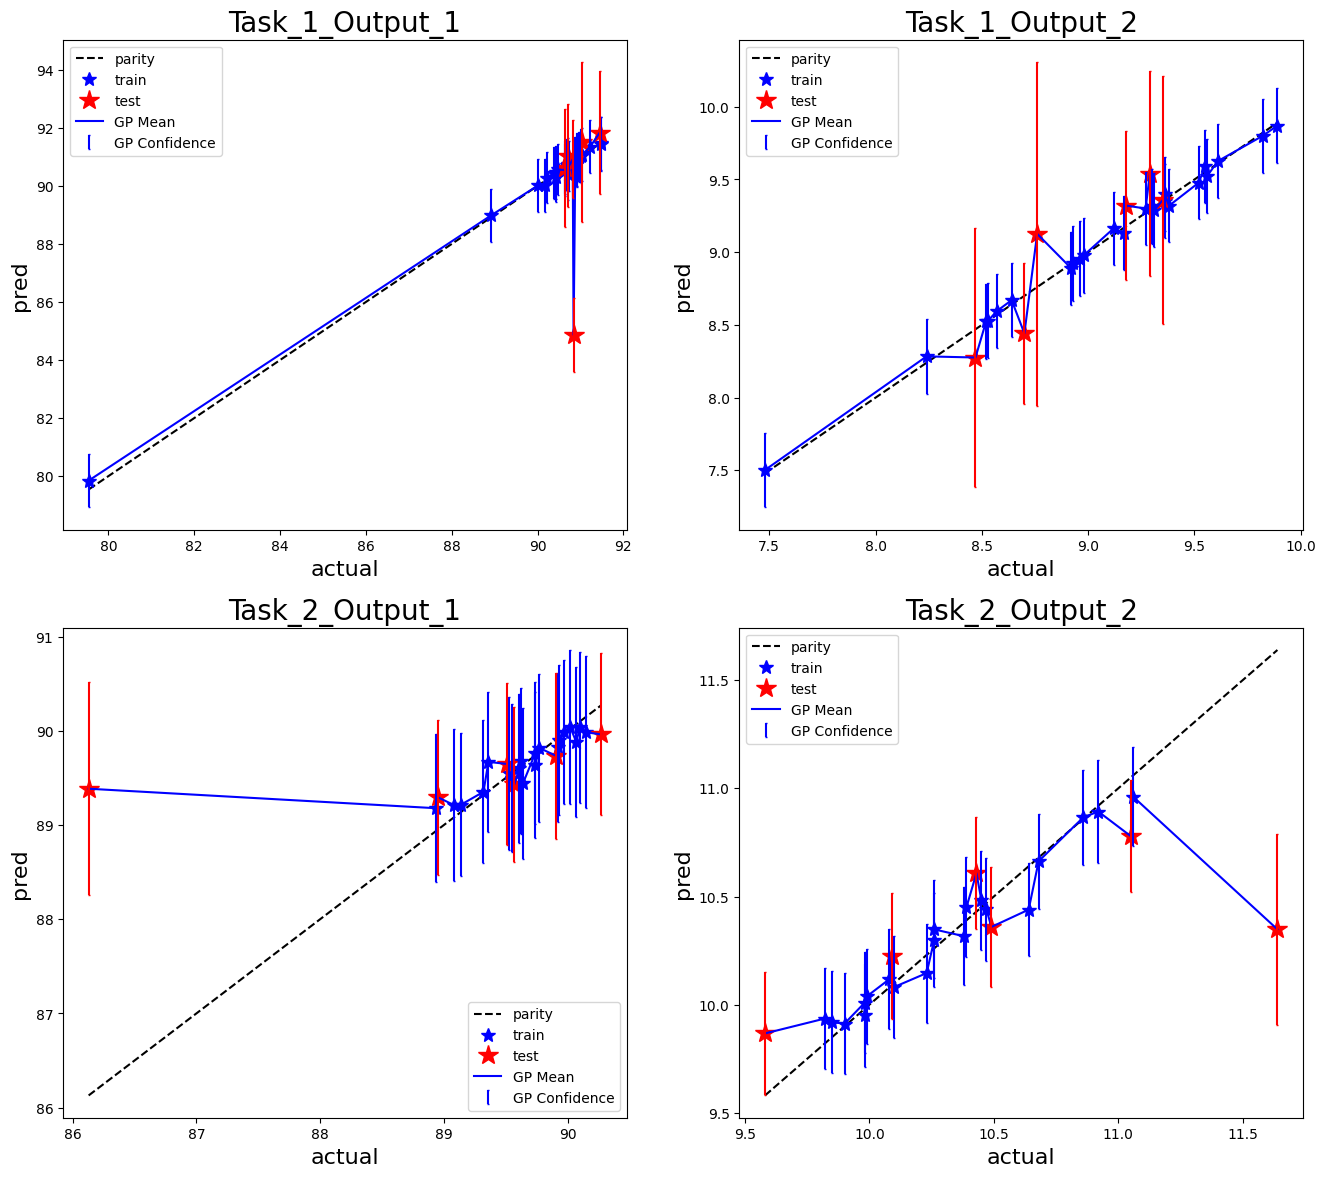

In [113]:
#from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_wide = []

plot_axis_lb = df_y.min(axis = 0) - 0.4 * df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4 * df_y.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = len(ls_df_x)

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+str(j+1)
    cols_target_wide.append(tmp_col_y)

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    #y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1),fontsize=20)
    y_axes[a].set_xlabel('actual',fontsize=16)
    y_axes[a].set_ylabel('pred',fontsize=16)

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## BO

In [52]:
np.random.seed(2024)
n_buffer_level = df_x_select['Buffer_label'].unique().shape[0]


In [63]:
from botorch.models.multitask import MultiTaskGP
from botorch import fit_gpytorch_mll

bo_gp_model = MultiTaskGP(t_train_x,t_train_y,task_feature=-1)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )


In [71]:
#https://botorch.org/tutorials/multi_objective_bo
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")
SMOKE_TEST = True

In [196]:
from botorch.models.gp_regression import FixedNoiseGP, SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.models.multitask import MultiTaskGP

NOISE_SE = torch.tensor([15.19, 0.63], **tkwargs)


def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj, x_bounds):
    # define models for objective and constraint
    train_x = normalize(train_x, x_bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        """
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            FixedNoiseGP(
                train_x, train_y, train_yvar, outcome_transform=Standardize(m=1)
            )
        )
        """
        models.append(
            SingleTaskGP(
                train_x, train_y, outcome_transform=Standardize(m=1)
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

def initialize_model2(train_x, train_obj):
    # define models for objective and constraint
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        models.append(
            MultiTaskGP(train_x,train_y,task_feature=-1)
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [144]:
x_bounds = torch.zeros(2,len(cols_feature01))
x_bounds[0,:] = t_train_x[:,0:3].min(axis = 0).values
x_bounds[1,:] = t_train_x[:,0:3].max(axis = 0).values

ref_points = t_train_y.max(axis = 0).values
ref_points

tensor([1., 1.])

In [219]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 4
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, len(cols_feature01), **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, x_bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=ref_points,
        Y=pred,
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_points,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=x_bounds)
    #new_x = candidates.detach()
    #new_obj_true = problem(new_x)
    new_obj_true = model.posterior(new_x).mean
    #new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj_true

In [218]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qNParEGO acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, x_bounds)
    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(len(cols_target), **tkwargs).squeeze()
        objective = GenericMCObjective(
            get_chebyshev_scalarization(weights=weights, Y=pred)
        )
        acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=x_bounds)
    new_obj_true = model.posterior(new_x).mean
    return new_x, new_obj_true

In [220]:
def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_points.tolist(),  # use known reference point
        X_baseline=normalize(train_x, x_bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=x_bounds)
    new_obj_true = model.posterior(new_x).mean
    #new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj_true

In [221]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 5
MC_SAMPLES = 128 if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qehvi, hvs_qnehvi, hvs_random = [], [], [], []

# call helper functions to generate initial training data and initialize model

train_x_qparego, train_obj_qparego = t_train_x[:,0:3].double(), t_train_y.double()
#train_obj_qparego = train_obj_true_qparego + torch.randn_like(train_obj_true_qparego) * NOISE_SE

mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego,x_bounds)

In [222]:
train_x_qehvi, train_obj_qehvi= (
    train_x_qparego,
    train_obj_qparego,
)
train_x_qnehvi, train_obj_qnehvi= (
    train_x_qparego,
    train_obj_qparego,
)
train_x_random, train_obj_random= (
    train_x_qparego,
    train_obj_qparego,
)
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi,x_bounds)
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi,x_bounds)

# compute hypervolume
bd = DominatedPartitioning(ref_point=ref_points, Y=train_obj_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qehvi.append(volume)
hvs_qnehvi.append(volume)
hvs_random.append(volume)

In [225]:
# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):

    t0 = time.monotonic()

    # fit the models
    fit_gpytorch_mll(mll_qparego)
    fit_gpytorch_mll(mll_qehvi)
    fit_gpytorch_mll(mll_qnehvi)

    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
    (
        new_x_qparego,
        new_obj_qparego,
        #new_obj_true_qparego,
    ) = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_qparego, qparego_sampler
    )
    new_x_qehvi, new_obj_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_qehvi, qehvi_sampler
    )
    (
        new_x_qnehvi,
        new_obj_qnehvi,
        #new_obj_true_qnehvi,
    ) = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_qnehvi, qnehvi_sampler
    )
    """
    new_x_random, new_obj_random = generate_initial_data(
        n=BATCH_SIZE
    )
    """
    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
    #train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    #train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])

    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
    #train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])
    """
    train_x_random = torch.cat([train_x_random, new_x_random])
    train_obj_random = torch.cat([train_obj_random, new_obj_random])
    train_obj_true_random = torch.cat([train_obj_true_random, new_obj_true_random])
    """
    # update progress
    for hvs_list, train_obj in zip(
        (hvs_qparego, hvs_qehvi, hvs_qnehvi),
        (
            #train_obj_true_random,
            train_obj_qparego,
            train_obj_qehvi,
            train_obj_qnehvi,
        ),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=ref_points, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego,x_bounds)
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi,x_bounds)
    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi,x_bounds)

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (qNParEGO, qEHVI, qNEHVI) = "
            f"({hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.DoubleTensor []] is at version 23; expected version 21 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [215]:
model_tmp = SingleTaskGP(t_train_x[:,0:3].double(), t_train_y[:,0].double().reshape(-1,1))
model_tmp.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model_tmp.likelihood, model_tmp)
optimizer = torch.optim.Adam(model_tmp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

training_iterations=10
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model_tmp(t_train_x[:,0:3].double())
    loss = -mll(output, t_train_y[:,0].double())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

model_tmp.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    result = model_tmp(new_x_qparego)
result

Iter 1/10 - Loss: 1.449
Iter 2/10 - Loss: 1.419
Iter 3/10 - Loss: 1.388
Iter 4/10 - Loss: 1.356
Iter 5/10 - Loss: 1.322
Iter 6/10 - Loss: 1.286
Iter 7/10 - Loss: 1.249
Iter 8/10 - Loss: 1.210
Iter 9/10 - Loss: 1.168
Iter 10/10 - Loss: 1.124


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8566], dtype=torch.float64), std = tensor([0.1202], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


MultivariateNormal(loc: torch.Size([4]))

In [217]:
model_qparego.posterior(new_x_qparego).mean

tensor([[0.7854, 0.5678],
        [0.8909, 0.5358],
        [0.8397, 0.6120],
        [0.8853, 0.5800]], dtype=torch.float64, grad_fn=<CloneBackward0>)